# Content-based Recommendation Baseline

Inspired by [Deep content-based music recommendation](https://papers.nips.cc/paper/5004-deep-content-based-music-recommendation.pdf) by van den Oord, Dieleman 

Instead of using MFCC, which would require getting the music files, we use the timbre features which are already provided by the EchoNest API. Code here is taken from/based on the source for the [Notebooks](https://github.com/dawenl/stochastic_PMF) for [Codebook-based Scalable Music Tagging with Poisson Matrix Factorization](http://dawenl.github.io/publications/LiangPE14-codebook.pdf) by Dawen Liang, John Paisley and Dan Ellis, in ISMIR 2014, with slight modifications.

## Vector Quantized Representations of Segments

In [1]:
import json
import numpy as np
import pickle
import os
from constants import Dataset, TasteProfileDataset, MSDChallengeDataset
from lib import hdf5_getters
from lib import metrics
from lib.hartigan import HartiganOnline
from lib.quantize import VectorQuantizer
from matplotlib import pyplot as plt

In [2]:
from collections import defaultdict

def get_all_unique_tracks(ConstantClass, cache_dir=os.path.join(".", "data", "cache")):
    tracks = set()
    track_to_song_mappings = defaultdict(list)
    song_to_track_mappings = {}
    track_cache_path = os.path.join(cache_dir, "tracks.json")
    track_to_song_cache_path = os.path.join(cache_dir, "track_to_song.json")
    song_to_track_cache_path = os.path.join(cache_dir, "song_to_track.json")

    if os.path.exists(track_cache_path) and os.path.exists(track_to_song_cache_path) and os.path.exists(song_to_track_cache_path):
        track_cache_f = open(track_cache_path, "r")
        track_to_song_cache_f = open(track_to_song_cache_path, "r")
        song_to_track_cache_f = open(song_to_track_cache_path, "r")
        
        tracks = json.load(track_cache_f)
        track_to_song_mappings = json.load(track_to_song_cache_f)
        song_to_track_mappings = json.load(song_to_track_cache_f)
        
        track_cache_f.close()
        track_to_song_cache_f.close()
        song_to_track_cache_f.close()
        
        return tracks, track_to_song_mappings, song_to_track_mappings

    with open(ConstantClass.MSD_UNIQ_TRACKS_PATH, 'rb') as f:
        for (count, line) in enumerate(f):
            track_id, _, _, _ = line.decode("utf-8").strip().split("<SEP>")
            tracks.add(track_id)
            
            track_dir = os.path.join(ConstantClass.MSD_DATA_DIR, '/'.join(track_id[2:5]), f'{track_id}.h5')
            h5 = hdf5_getters.open_h5_file_read(track_dir)
            for i in range(hdf5_getters.get_num_songs(h5)):
                song_id = hdf5_getters.get_song_id(h5, i).decode('utf-8')
                track_to_song_mappings[track_id].append(song_id)
                song_to_track_mappings[song_id] = track_id
            h5.close()
            
            if count % 1000 == 0:
                print(f"{count} tracks processed")

    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)
    
    tracks = list(tracks)
    
    with open(track_cache_path, "w") as f:
        json.dump(tracks, f)
    
    with open(track_to_song_cache_path, "w") as f:
        json.dump(track_to_song_mappings, f)
    
    with open(song_to_track_cache_path, "w") as f:
        json.dump(song_to_track_mappings, f)
    
    return tracks, track_to_song_mappings, song_to_track_mappings

In [3]:
uniq_tracks, track_id_to_song_id, song_id_to_track_id = get_all_unique_tracks(Dataset)

## Vector Quantization

VQ allows us to get a feature representation.

In [4]:
def data_generator(ConstantClass, tracks, shuffle=True, ext=".h5"):
    if shuffle:
        np.random.shuffle(list(tracks))

    for track_id in tracks:
        track_dir = os.path.join(ConstantClass.MSD_DATA_DIR, '/'.join(track_id[2:5]), track_id + ext)
        h5 = hdf5_getters.open_h5_file_read(track_dir)
        for i in range(hdf5_getters.get_num_songs(h5)):
            timbre = hdf5_getters.get_segments_timbre(h5, i)
            if shuffle:
                np.random.shuffle(timbre)
            yield timbre
        h5.close()


def build_codewords(ConstantClass, tracks, n_clusters=2, max_iter=10, random_state=None, cluster=None):
    if type(random_state) is int:
        np.random.seed(random_state)
    elif random_state is not None:
        np.random.set_state(random_state)
 
    if cluster is None:
        cluster = HartiganOnline(n_clusters)

    for i in range(max_iter):
        print(f"Iteration {i+1}: Passing through the data...")
        for d in data_generator(ConstantClass, tracks):
            cluster.partial_fit(d)

    return cluster

In [5]:
def get_codewords(ConstantClass, tracks, n_clusters, max_iter, random_state, cache_dir=os.path.join(".", "data", "cache")):
    cache_path = os.path.join(cache_dir, "cluster.pkl")
    
    if os.path.exists(cache_path):
        with open(cache_path, "rb") as f:
            cluster = pickle.load(f)
            return cluster

    cluster = build_codewords(ConstantClass, tracks, n_clusters, max_iter, random_state)
    
    with open(cache_path, "wb") as f:
        pickle.dump(cluster, f)
    
    return cluster

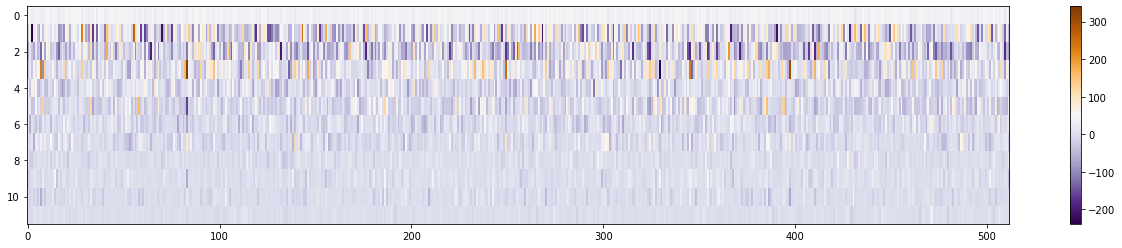

In [6]:
K = 512
codebook = get_codewords(Dataset, uniq_tracks, n_clusters=K, max_iter=3, random_state=98765)
plt.figure(figsize=(22, 4))
plt.imshow(codebook.cluster_centers_.T, cmap="PuOr_r", aspect="auto", interpolation="nearest")
plt.colorbar()

### Build a bag-of-word representation of each song

Each song, $s_i$, is a $K$-dimensional vector, where element $j$ menas the number of times the $j$th centroid has been matched. 

In [7]:
def build_idx_to_song_id_mapping():
    idx_to_song_id_mapping = {}
    song_id_to_idx_mapping = {}
    running_idx = 0
    for track_i, track_id in enumerate(uniq_tracks):
        for song_id in track_id_to_song_id[track_id]:
            idx_to_song_id_mapping[running_idx] = song_id
            song_id_to_idx_mapping[song_id] = running_idx
            running_idx += 1
    return idx_to_song_id_mapping, song_id_to_idx_mapping

idx_to_song_id_mapping, song_id_to_idx_mapping = build_idx_to_song_id_mapping()

In [5]:
vq = VectorQuantizer(clusterer=codebook)
vq.center_norms_ = 0.5 * (vq.clusterer.cluster_centers_ ** 2).sum(axis=1)
vq.components_ = vq.clusterer.cluster_centers_

song_bow = np.zeros((len(song_id_to_idx_mapping), K))

def quantize_and_save(vq, K, msd_data_root, track_id, song_id, song_idx=0):
    hist_dir = os.path.join("data", "vq_hist", "/".join(track_id[2:5]))
    if not os.path.exists(hist_dir):
        os.makedirs(hist_dir)

    vq_path = os.path.join(hist_dir, track_id + '_' + song_id + '_K%d' % K)
    if os.path.exists(os.path.join(vq_path) + '.npy'):
        return np.load(os.path.join(vq_path) + '.npy')
    
    track_dir = os.path.join(msd_data_root, '/'.join(track_id[2:5]), track_id + '.h5')
    h5 = hdf5_getters.open_h5_file_read(track_dir)
    timbre = hdf5_getters.get_segments_timbre(h5, song_idx)
    h5.close()

    vq_hist = vq.transform(timbre).sum(axis=0).astype(np.int16)
    np.save(os.path.join(hist_dir, track_id + '_' + song_id + '_K%d' % K), vq_hist)
    return vq_hist


for track_id in uniq_tracks:
    for song_idx, song_id in enumerate(track_id_to_song_id[track_id]):
        song_bow[song_id_to_idx_mapping[song_id]] = quantize_and_save(vq, K, SubsetDataset.MSD_DATA_DIR, track_id, song_id, song_idx)

NameError: name 'codebook' is not defined

In [8]:
len(song_id_to_idx_mapping)

999056

## Get Latent Factors for Users

Source: [Deep Content-based Music Recommendation](https://papers.nips.cc/paper/5004-deep-content-based-music-recommendation.pdf)

### Build user-item matrix

In [9]:
def get_uniq_users(profile_path, cache_dir=os.path.join('.', 'data', 'cache')):
    users = set()
    profile_name = os.path.basename(profile_path).split('.')
    if len(profile_name) > 1:
        profile_name = profile_name[:-1]
    cache_path = os.path.join(cache_dir, f'users-{profile_name}.json')

    if os.path.exists(cache_path):
        with open(cache_path, 'r') as f:
            return json.load(f)

    with open(profile_path, 'r') as f:
        for (count, line) in enumerate(f):
            user_id = line.strip().split('\t')[0]
            users.add(user_id)
            if count % 100000 == 0:
                print(f'{count} listening history processed')

    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)
    
    users = list(users)
    with open(cache_path, 'w') as f:
        json.dump(users, f)
    
    return users

In [18]:
uniq_users = get_uniq_users(TasteProfileDataset.TPD_ORIG_TRAIN_PATH)

In [11]:
uniq_user_to_idx = {user_id: i for i, user_id in enumerate(uniq_users)}
idx_to_uniq_user = {i: user_id for i, user_id in enumerate(uniq_users)}

In [12]:
uniq_track_to_idx = {track_id: i for i, track_id in enumerate(uniq_tracks)}
idx_to_uniq_track = {i: track_id for i, track_id in enumerate(uniq_tracks)}

In [13]:
import importlib
from lib import song_subset
importlib.reload(song_subset)

train_tpd = TasteProfileDataset.TPD_ORIG_TRAIN_PATH
val_msc_visible = MSDChallengeDataset.MSDC_EVAL_VISIBLE_PATH
val_msc_hidden = MSDChallengeDataset.MSDC_EVAL_HIDDEN_PATH
test_msc_visible = MSDChallengeDataset.MSDC_TEST_VISIBLE_PATH
test_msc_hidden = MSDChallengeDataset.MSDC_TEST_HIDDEN_PATH

valid_songs = song_subset.get_trainable_songs([train_tpd])
valid_songs = valid_songs & set(song_id_to_track_id.keys())

print('Total Songs:', len(valid_songs))

Total Songs: 384546


In [14]:
import pandas as pd

valid_song_list = list(valid_songs)
valid_song_list_i_to_song = {v: i for i, v in enumerate(valid_song_list)}
song_categories = pd.Series(valid_song_list, dtype="category")
song_categories

0         SOLAOJW12A6D4F7F07
1         SOTVFGR12AB018BEB0
2         SOWFFTW12A8C131C4B
3         SOITXVI12AB0181E4B
4         SOLZRWG12A8C138C6B
                 ...        
384541    SOGGPZZ12AB017F94E
384542    SOVQPVA12A8C141927
384543    SOEDXTX12AB017DEFA
384544    SOAGZZV12AB017EC83
384545    SOFIRQJ12A81C22D26
Length: 384546, dtype: category
Categories (384546, object): [SOAAADD12AB018A9DD, SOAAADE12A6D4F80CC, SOAAADF12A8C13DF62, SOAAADZ12A8C1334FB, ..., SOZZZRV12A8C1361F1, SOZZZSR12AB01854CD, SOZZZWD12A6D4F6624, SOZZZWN12AF72A1E29]

In [15]:
def get_user_play_array(line, transform_cui=lambda x: x if x > 0 else 0):
    user_id, song_id, play_count = line.strip().split("\t")
    if song_id not in valid_songs:
        return None

    return [user_id, song_id, transform_cui(int(play_count))]

In [19]:
import pandas as pd
from scipy.sparse import coo_matrix


def build_user_item_matrix(profile_path, song_categories=None, song_to_idx_map=None, transform_cui=lambda x: x if x > 0 else 0, uniq_users=uniq_users):
    user_to_item_plays = []
    
    successful = 0
    with open(profile_path, 'r') as f:
        for (count, line) in enumerate(f):
            if count % 100000 == 0:
                print(f"{count} listening history processed")
                
            user_play = get_user_play_array(line, transform_cui)
            
            if user_play is None:
                continue
                
            user_to_item_plays.append(user_play)
            
            successful += 1
    
    user_to_item_plays = pd.DataFrame(user_to_item_plays, columns=['user_id', 'track_id', 'plays'])
    user_to_item_plays['user_id'] = user_to_item_plays['user_id'].astype('category')
    user_to_item_plays['track_id'] = user_to_item_plays['track_id'].astype('category')
    
    if song_categories is not None and song_to_idx_map is not None:
        user_to_item_plays['track_id'].cat = song_categories
        user_to_item_plays['track_id'] = user_to_item_plays['track_id'].map(song_to_idx_map)

        user_item = coo_matrix((user_to_item_plays['plays'], (user_to_item_plays['user_id'].cat.codes, user_to_item_plays['track_id'])), shape=(len(uniq_users), len(song_categories)))
    else:
        user_item = coo_matrix((user_to_item_plays['plays'], (user_to_item_plays['user_id'].cat.codes, user_to_item_plays['track_id'].cat.codes)))
    
    return user_item.tocsr(), user_to_item_plays['user_id'].cat.categories, user_to_item_plays['track_id'].cat.categories

In [20]:
import math

def transform_cui(play_count):
    if play_count == 0:
        return 0
    
    alpha = 0.9
    epsilon = 0.01
    return 1 + alpha * math.log(1 + play_count / epsilon)

user_item_matrix, user_cat, item_cat = build_user_item_matrix(TasteProfileDataset.TPD_ORIG_TRAIN_PATH, song_categories, valid_song_list_i_to_song, transform_cui)

0 listening history processed
100000 listening history processed
200000 listening history processed
300000 listening history processed
400000 listening history processed
500000 listening history processed
600000 listening history processed
700000 listening history processed
800000 listening history processed
900000 listening history processed
1000000 listening history processed
1100000 listening history processed
1200000 listening history processed
1300000 listening history processed
1400000 listening history processed
1500000 listening history processed
1600000 listening history processed
1700000 listening history processed
1800000 listening history processed
1900000 listening history processed
2000000 listening history processed
2100000 listening history processed
2200000 listening history processed
2300000 listening history processed
2400000 listening history processed
2500000 listening history processed
2600000 listening history processed
2700000 listening history processed
2800000

22500000 listening history processed
22600000 listening history processed
22700000 listening history processed
22800000 listening history processed
22900000 listening history processed
23000000 listening history processed
23100000 listening history processed
23200000 listening history processed
23300000 listening history processed
23400000 listening history processed
23500000 listening history processed
23600000 listening history processed
23700000 listening history processed
23800000 listening history processed
23900000 listening history processed
24000000 listening history processed
24100000 listening history processed
24200000 listening history processed
24300000 listening history processed
24400000 listening history processed
24500000 listening history processed
24600000 listening history processed
24700000 listening history processed
24800000 listening history processed
24900000 listening history processed
25000000 listening history processed
25100000 listening history processed
2

44800000 listening history processed
44900000 listening history processed
45000000 listening history processed
45100000 listening history processed
45200000 listening history processed
45300000 listening history processed
45400000 listening history processed
45500000 listening history processed
45600000 listening history processed
45700000 listening history processed
45800000 listening history processed
45900000 listening history processed
46000000 listening history processed
46100000 listening history processed
46200000 listening history processed
46300000 listening history processed
46400000 listening history processed
46500000 listening history processed
46600000 listening history processed
46700000 listening history processed
46800000 listening history processed
46900000 listening history processed
47000000 listening history processed
47100000 listening history processed
47200000 listening history processed
47300000 listening history processed
47400000 listening history processed
4

In [21]:
print(user_item_matrix.get_shape())

(1019318, 384546)


In [22]:
import implicit

model = implicit.als.AlternatingLeastSquares(factors=64)
model.fit(item_users=user_item_matrix.T)

train_user_factors = model.user_factors.copy()
train_item_factors = model.item_factors.copy()

In [23]:
print(model.item_factors.shape)

(384546, 64)


In [24]:
def get_user_songs(profile_path, intersect=None):
    songs = {}
    
    with open(profile_path, 'r') as f:
        for (count, line) in enumerate(f):
            user_id, song_id, _ = line.strip().split("\t")
            
            if user_id not in songs:
                songs[user_id] = set([song_id])
            else:
                songs[user_id].add(song_id)
    
    if intersect is not None:
        for user_id in songs:
            songs[user_id] &= intersect
    
    return songs


def build_predicted_and_actual_songs(predicted_user_songs, actual_user_songs, n=None):
    predicted_songs = []
    actual_songs = []
    
    for user_i, user_items in enumerate(recommendations):
        if n is not None and user_i >= n:
            break
            
        predicted_songs_for_user = []
        for item in user_items:
            predicted_songs_for_user += [song_categories[item]]
        predicted_songs += [predicted_songs_for_user]
        actual_songs += [list(actual_user_songs[user_cat[user_i]])]
    
    return predicted_songs, actual_songs


In [26]:
recommendations = model.recommend_all(user_item_matrix, 10)

actual_user_songs = get_user_songs(train_tpd, valid_songs)
predicted_songs, actual_songs = build_predicted_and_actual_songs(recommendations, actual_user_songs)

print(metrics.mean_average_precision(predicted_songs, actual_songs))


0.0


## Load Evaluation Data

We need to discard recommended songs that are not actually in the (sub-)dataset.

### Evaluating Predictions with User-Item Matrix

In [23]:
eval_user_item_matrix, user_cat, item_cat = build_user_item_matrix(MSDChallengeDataset.MSDC_EVAL_VISIBLE_PATH, song_categories, valid_song_list_i_to_song, transform_cui)

0 listening history processed
100000 listening history processed


In [24]:
recommendations = model.recommend_all(eval_user_item_matrix, recalculate_user=True)

In [25]:
recommendations.shape

(1019318, 10)

In [ ]:

actual_user_songs = get_user_songs(MSDChallengeDataset.MSDC_EVAL_HIDDEN_PATH)
predicted_songs, actual_songs = build_predicted_and_actual_songs(recommendations, actual_user_songs, len(actual_user_songs))


eval_user_factors = model.user_factors.copy()
eval_item_factors = model.item_factors.copy()

In [27]:
metrics.mean_average_precision(predicted_songs, actual_songs)

0.032494115079365074

### Test

In [42]:
test_valid_songs = song_subset.get_trainable_songs([test_msc_visible, test_msc_hidden])
test_valid_songs &= set(song_id_to_track_id.keys())
test_valid_song_list = list(train_valid_songs)
test_valid_song_list_i_to_song = {v: i for i, v in enumerate(valid_song_list)}
test_uniq_users = get_uniq_users(MSDChallengeDataset.MSDC_TEST_VISIBLE_PATH)

test_song_categories = pd.Series(test_valid_song_list, dtype="category")
test_song_categories

0 listening history processed
100000 listening history processed
200000 listening history processed
300000 listening history processed
400000 listening history processed
500000 listening history processed
600000 listening history processed
700000 listening history processed
800000 listening history processed
900000 listening history processed
1000000 listening history processed
1100000 listening history processed
1200000 listening history processed
1300000 listening history processed


0       SOUGYSM12AAF3B244C
1       SOPVMHA12A67ADC096
2       SOIKYAU12A8C134B6C
3       SOXWHJD12AB018606C
4       SOWGDDU12AF72A03DA
               ...        
9325    SOBMKJU12A6D4F7128
9326    SOFGIVB12A6D4F5923
9327    SOBOHKS12A67AD72E3
9328    SOGWZFC12A58A778BF
9329    SODKTIY12AB0188309
Length: 9330, dtype: category
Categories (9330, object): [SOAAAGQ12A8C1420C8, SOAACPJ12A81C21360, SOAACSG12AB018DC80, SOAAFAC12A67ADF7EB, ..., SOZZTNF12A8C139916, SOZZVWB12AB0189C30, SOZZWZV12A67AE140F, SOZZZPV12A8C1444B5]

In [46]:
test_user_item_matrix, user_cat, item_cat = build_user_item_matrix(MSDChallengeDataset.MSDC_TEST_VISIBLE_PATH, test_song_categories, test_valid_song_list_i_to_song, transform_cui, test_uniq_users)

0 listening history processed
100000 listening history processed
200000 listening history processed
300000 listening history processed
400000 listening history processed
500000 listening history processed
600000 listening history processed
700000 listening history processed
800000 listening history processed
900000 listening history processed
1000000 listening history processed
1100000 listening history processed
1200000 listening history processed
1300000 listening history processed


In [47]:
recommendations = model.recommend_all(test_user_item_matrix, recalculate_user=True)

In [63]:
len(user_cat)

97240

In [66]:

actual_user_songs = get_user_songs(MSDChallengeDataset.MSDC_TEST_HIDDEN_PATH)
predicted_songs, actual_songs = build_predicted_and_actual_songs(recommendations, actual_user_songs, len(user_cat))

metrics.mean_average_precision(predicted_songs, actual_songs)

0.032025267216443686

---

## Using LSTM to Make Predictions

The idea is to predict the latent factors from the audio features (framed as a regression problem) to make 
predictions.

In [17]:
import torch
import time
from torch import randperm
from torch._utils import _accumulate

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [18]:
from torch import nn
from torch.utils.data import Dataset


class MillionSongDataset__Preloaded(Dataset):
    """MillionSongDataset__Preloaded is for the notebook version where
    much of the data is already in memory.
    """
    
    def __init__(self, song_id_to_track_id, valid_song_list, latent_factors, ConstantClass):
        self.song_id_to_track_id = song_id_to_track_id
        self.valid_song_list = valid_song_list
        self.ConstantClass = ConstantClass
        self.latent_factors = latent_factors
    
    def __len__(self):
        return len(self.valid_song_list)
    
    def __getitem__(self, idx):
        song_id = self.valid_song_list[idx]
        track_id = self.song_id_to_track_id[song_id]
        track_dir = os.path.join(self.ConstantClass.MSD_DATA_DIR, '/'.join(track_id[2:5]), track_id + '.h5')
        h5 = hdf5_getters.open_h5_file_read(track_dir)
        
        for i in range(hdf5_getters.get_num_songs(h5)):
            sid = hdf5_getters.get_song_id(h5, i).decode('utf-8')
            if sid != song_id:
                continue
            timbre = torch.Tensor(hdf5_getters.get_segments_timbre(h5, i))
        
        h5.close()
        
        if idx >= len(self.latent_factors):
            latent_factors = None
        else:
            latent_factors = torch.Tensor(self.latent_factors[idx])

        return timbre, latent_factors


class Subset(Dataset):
    """
    Subset of a dataset at specified indices.

    Arguments:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
    """
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

    def __len__(self):
        return len(self.indices)

    
def random_split(dataset, lengths):
    r"""
    Randomly split a dataset into non-overlapping new datasets of given lengths.

    Arguments:
        dataset (Dataset): Dataset to be split
        lengths (sequence): lengths of splits to be produced
    """
    if sum(lengths) != len(dataset):
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = randperm(sum(lengths)).tolist()
    return [Subset(dataset, indices[offset - length:offset]) for offset, length in zip(_accumulate(lengths), lengths)]


In [19]:
from torch.nn.utils.rnn import pack_padded_sequence

class LSTMToLatentFactor(nn.Module):
    def __init__(self, input_dim=12, hidden_dim=72, output_dim=64):
        super(LSTMToLatentFactor, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, batch):
        sequences, sequence_lengths, _ = batch
        sequences_packed = pack_padded_sequence(sequences, sequence_lengths, batch_first=True).to(device)
        h0 = torch.zeros([1, sequences.shape[0], self.hidden_dim], dtype=torch.float).to(device)
        c0 = torch.zeros([1, sequences.shape[0], self.hidden_dim], dtype=torch.float).to(device)
        lstm_out, (h, c) = self.lstm(sequences_packed, (h0, c0))
        final_h = h[-1]
        regressor_out = self.linear(final_h.view(sequences.shape[0], -1))
        return regressor_out


In [20]:
def collate_fn(batch):
    """Because songs have different lengths, let's pad them to uniform lengths."""
    # https://www.codefull.net/2018/11/use-pytorchs-dataloader-with-variable-length-sequences-for-lstm-gru/
    sorted_pairs = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
    sequences = [torch.Tensor(x[0]) for x in sorted_pairs]
    sequences_padded = nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    lengths = torch.Tensor([sequence.shape[0] for sequence in sequences])
    if sorted_pairs[0][1] is None:
        latent_f = None
    else:
        latent_f = torch.FloatTensor([x[1].numpy() for x in sorted_pairs])
    return sequences_padded, lengths, latent_f

In [21]:
# https://nusit.nus.edu.sg/technus/hpc/deep-learning-best-practices-checkpointing-deep-learning-model-training/

import shutil


def has_checkpoint(checkpoint, is_best=False):
    if is_best:
        filepath = os.path.join(checkpoint, 'best.pth.tar')
    else:
        filepath = os.path.join(checkpoint, 'last.pth.tar')
    return os.path.exists(filepath)


def save_checkpoint(state, is_best, checkpoint):
    """Saves model and training parameters at checkpoint + 'last.pth.tar'. If is_best==True, also saves
    checkpoint + 'best.pth.tar'
    Args:
        state: (dict) contains model's state_dict, may contain other keys such as epoch, optimizer state_dict
        is_best: (bool) True if it is the best model seen till now
        checkpoint: (string) folder where parameters are to be saved
    """
    filepath = os.path.join(checkpoint, 'last.pth.tar')
    if not os.path.exists(checkpoint):
        print("Checkpoint directory does not exist. Making directory {}".format(checkpoint))
        os.makedirs(checkpoint)
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'best.pth.tar'))


def load_checkpoint(checkpoint, model, optimizer=None):
    """Loads model parameters (state_dict) from file_path. If optimizer is provided, loads state_dict of
    optimizer assuming it is present in checkpoint.
    Args:
        checkpoint: (string) filename which needs to be loaded
        model: (torch.nn.Module) model for which the parameters are loaded
        optimizer: (torch.optim) optional: resume optimizer from checkpoint
    """
    if not os.path.exists(checkpoint):
        raise("File doesn't exist {}".format(checkpoint))
    checkpoint = torch.load(checkpoint)
    model.load_state_dict(checkpoint['state_dict'])

    if optimizer:
        optimizer.load_state_dict(checkpoint['optim_dict'])

    return checkpoint

In [22]:
train_valid_songs = song_subset.get_trainable_songs([train_tpd])
train_valid_songs &= set(song_id_to_track_id.keys())
train_valid_song_list = list(train_valid_songs)

In [25]:
from constants import Dataset
from math import ceil

msd = MillionSongDataset__Preloaded(song_id_to_track_id, train_valid_song_list, train_item_factors, Dataset)
lstm_model = LSTMToLatentFactor().to(device)
train_data_count = int(len(train_valid_song_list) * 0.8)
valid_data_count = int(len(train_valid_song_list) * 0.1)
test_data_count = len(train_valid_song_list) - train_data_count - valid_data_count
train_dataset, valid_dataset, test_dataset = random_split(msd, [train_data_count, valid_data_count, test_data_count])

train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                batch_size=100,
                                                collate_fn=collate_fn)
valid_data_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                batch_size=100,
                                                collate_fn=collate_fn)

best_dev_mae = 10000000

learning_rate = 0.01
epochs = 2
save_every = 50
eval_every = 100
log_every = 10

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
checkpoint_path = os.path.join('.', 'model', 'checkpoints', 'lstm')
iterations = 0
start_epoch = 0

if has_checkpoint(checkpoint_path):
    print('Loading from last')
    checkpoint = load_checkpoint(os.path.join(checkpoint_path, 'last.pth.tar'), lstm_model)
    
    best_dev_mae = checkpoint['best_dev_mae']
    learning_rate = checkpoint['learning_rate']
    start_epoch = checkpoint['epoch']
    iterations = checkpoint['iterations']
    
print(best_dev_mae)

for epoch in range(start_epoch, epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    start_time = time.time()
    
    for batch_idx, batch in enumerate(train_data_loader):
        if iterations > batch_idx:
            print(f'skipping, because it = {iterations}, batch_idx = {batch_idx}')
            continue
        
        iterations += 1
        
        latent_factors = batch[2].to(device)
        
        lstm_model.train()
        optimizer.zero_grad()
        model_out = lstm_model(batch)
        loss = criterion(model_out, latent_factors)
        loss.backward()
        optimizer.step()
        
        if iterations % save_every == 0:
            print(f'Saving checkpoint at iteration {iterations}')
            
            save_checkpoint({
                'epoch': epoch,
                'iterations': iterations,
                'state_dict': lstm_model.state_dict(),
                'best_dev_mae': best_dev_mae,
                'learning_rate': learning_rate,
                'optim_dict': optimizer.state_dict(),
            }, False, checkpoint_path)
        
        if iterations % eval_every == 0:
            # switch model to evaluation mode
            lstm_model.eval()

            # calculate accuracy on validation set
            dev_mae = 0
            with torch.no_grad():
                for dev_batch in valid_data_loader:
                    dev_latent_factors = dev_batch[2].to(device)
                    dev_model_out = lstm_model(dev_batch)
                    dev_loss = criterion(dev_model_out, dev_latent_factors)
                    dev_mae += dev_loss.item()
                dev_mae /= math.ceil(valid_data_count / 100)

            print(f'{time.time()-start_time} Epoch: {epoch} Iterations: {iterations} MAE: {loss.item()} Dev MAE: {dev_mae}')

            # update best valiation set accuracy
            if dev_mae < best_dev_mae:
                best_dev_mae = dev_mae
                print('Saving best model yet')
                
                save_checkpoint({
                    'epoch': epoch,
                    'iterations': iterations,
                    'state_dict': lstm_model.state_dict(),
                    'best_dev_mae': best_dev_mae,
                    'learning_rate': learning_rate,
                    'optim_dict': optimizer.state_dict(),
                }, True, checkpoint_path)
        
        elif iterations % log_every == 0:
            print(f'{time.time()-start_time} Epoch: {epoch} Iterations: {iterations} MAE: {loss.item()}')
    
    iterations = 0

lstm_model.eval()

# calculate accuracy on validation set
dev_mae = 0
with torch.no_grad():
    for dev_batch in valid_data_loader:
        dev_latent_factors = dev_batch[2].to(device)
        dev_model_out = lstm_model(dev_batch)
        dev_loss = criterion(dev_model_out, dev_latent_factors)
        dev_mae += dev_loss.item()
    dev_mae /= math.ceil(valid_data_count / 100)

print(f'{time.time()-start_time} Epoch: {epoch} Iterations: {iterations} MAE: {loss.item()} Dev MAE: {dev_mae}')

# update best valiation set accuracy
if dev_mae < best_dev_mae:
    best_dev_mae = dev_mae
    print('Finally: saving the best model')

    save_checkpoint({
        'epoch': epoch,
        'iterations': iterations,
        'state_dict': lstm_model.state_dict(),
        'best_dev_mae': best_dev_mae,
        'learning_rate': learning_rate,
        'optim_dict': optimizer.state_dict(),
    }, True, checkpoint_path)
else:
    print('Finally: using the best model')
    load_checkpoint(os.path.join(checkpoint_path, 'best.pth.tar'), lstm_model)

10000000
Epoch 1/2
24.49906849861145 Epoch: 0 Iterations: 10 MAE: 0.003370123915374279
48.9764564037323 Epoch: 0 Iterations: 20 MAE: 0.0014200648292899132
71.74161863327026 Epoch: 0 Iterations: 30 MAE: 0.0006627278053201735
94.28798770904541 Epoch: 0 Iterations: 40 MAE: 0.0002064491854980588
Saving checkpoint at iteration 50
116.90074014663696 Epoch: 0 Iterations: 50 MAE: 0.0002304631780134514
139.4268729686737 Epoch: 0 Iterations: 60 MAE: 0.0010688412003219128
162.9614233970642 Epoch: 0 Iterations: 70 MAE: 0.00017302448395639658
Epoch 2/2
skipping, because it = 75, batch_idx = 0
skipping, because it = 75, batch_idx = 1
skipping, because it = 75, batch_idx = 2
skipping, because it = 75, batch_idx = 3
skipping, because it = 75, batch_idx = 4
skipping, because it = 75, batch_idx = 5
skipping, because it = 75, batch_idx = 6
skipping, because it = 75, batch_idx = 7
skipping, because it = 75, batch_idx = 8
skipping, because it = 75, batch_idx = 9
skipping, because it = 75, batch_idx = 10
sk

In [26]:
# Test the model.
load_checkpoint(os.path.join(checkpoint_path, 'best.pth.tar'), lstm_model)
test_data_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                batch_size=100,
                                                collate_fn=collate_fn)

lstm_model.eval()

test_mae = 0
with torch.no_grad():
    for test_batch in test_data_loader:
        print(test_batch[0].shape)
        test_latent_factors = test_batch[2].to(device)
        test_model_out = lstm_model(test_batch)
        test_loss = criterion(test_model_out, test_latent_factors)
        test_mae += test_loss.item()
    test_mae /= math.ceil(test_data_count / 100)

torch.Size([100, 3515, 12])
torch.Size([100, 3119, 12])
torch.Size([100, 2692, 12])
torch.Size([100, 1847, 12])
torch.Size([100, 2396, 12])
torch.Size([100, 2268, 12])
torch.Size([100, 7348, 12])
torch.Size([100, 3170, 12])
torch.Size([100, 2647, 12])
torch.Size([33, 2378, 12])


In [27]:
test_mae

0.00022805264597991481

## Make Some Recommendations!

In [29]:
# First, we get the user factors for these new users.
test_user_factors = model.user_factors[:user_item_matrix.shape[0], :]

In [30]:
len(valid_song_list)

9330

In [31]:
test_user_factors.shape

(20000, 64)

In [32]:
from tqdm import tqdm
from scipy.sparse import lil_matrix, csr_matrix
from constants import Dataset

full_msd = MillionSongDataset__Preloaded(song_id_to_track_id, valid_song_list, train_item_factors, Dataset)
full_item_factors = lil_matrix((len(valid_song_list), 64), dtype='f')

full_data_loader = torch.utils.data.DataLoader(dataset=full_msd,
                                               batch_size=100,
                                               collate_fn=collate_fn)

for batch_idx, batch in enumerate(tqdm(full_data_loader)):
    output = lstm_model(batch)
    output = output.to('cpu').detach().numpy()
    full_item_factors[batch_idx*100:min(batch_idx*100 + 100, len(valid_song_list))] = lil_matrix(output)


100%|██████████| 94/94 [02:48<00:00,  1.80s/it]


In [172]:
valid_song_list = list(valid_songs)
valid_song_list_i_to_song = {v: i for i, v in enumerate(valid_song_list)}
actual_user_songs = get_user_songs(train_tpd, valid_songs)

In [176]:
def max_n(row_data, row_indices, n):
    # https://stackoverflow.com/questions/31790819/scipy-sparse-csr-matrix-how-to-get-top-ten-values-and-indices
    i = row_data[0].argsort()[0, -n:]
    top_values = row_data[0, i]
    top_indices = row_indices[0, i]  # do the sparse indices matter?
    return top_values, top_indices, i

Rui = lil_matrix((test_user_factors.shape[0], len(valid_song_list)), dtype='float')
ap = 0

full_item_factors_dense = full_item_factors.todense()

for i in tqdm(range(len(test_user_factors))):
    Rui[i] = test_user_factors[None, i].dot(full_item_factors_dense.T)
    _, top_songs, _ = max_n(Rui[i].todense(), np.array([range(len(valid_song_list))]), 30)
    ap += metrics.average_precision([valid_song_list[i] for i in top_songs[0]], actual_user_songs[user_cat[i]])


















  0%|          | 0/20000 [00:00<?, ?it/s]
















  0%|          | 17/20000 [00:00<02:03, 161.35it/s]
















  0%|          | 33/20000 [00:00<02:04, 160.90it/s]
















  0%|          | 50/20000 [00:00<02:04, 160.87it/s]
















  0%|          | 67/20000 [00:00<02:03, 161.41it/s]
















  0%|          | 84/20000 [00:00<02:02, 161.99it/s]
















  1%|          | 101/20000 [00:00<02:02, 162.19it/s]
















  1%|          | 118/20000 [00:00<02:02, 162.28it/s]
















  1%|          | 135/20000 [00:00<02:02, 162.47it/s]
















  1%|          | 152/20000 [00:00<02:02, 162.36it/s]
















  1%|          | 169/20000 [00:01<02:02, 162.53it/s]
















  1%|          | 186/20000 [00:01<02:01, 162.69it/s]
















  1%|          | 203/20000 [00:01<02:01, 162.67it/s]
















  1%|          | 220/20000 [00:01<02:01, 162.75it/s]
















  1%|          | 237/20000 [00:01

 10%|█         | 2092/20000 [00:13<02:00, 148.17it/s]
















 11%|█         | 2107/20000 [00:14<02:00, 148.45it/s]
















 11%|█         | 2122/20000 [00:14<02:00, 148.90it/s]
















 11%|█         | 2138/20000 [00:14<01:59, 149.70it/s]
















 11%|█         | 2154/20000 [00:14<01:59, 149.82it/s]
















 11%|█         | 2169/20000 [00:14<02:00, 148.32it/s]
















 11%|█         | 2184/20000 [00:14<02:00, 147.82it/s]
















 11%|█         | 2199/20000 [00:14<02:00, 147.71it/s]
















 11%|█         | 2214/20000 [00:14<02:00, 147.89it/s]
















 11%|█         | 2229/20000 [00:14<01:59, 148.13it/s]
















 11%|█         | 2244/20000 [00:14<01:59, 148.19it/s]
















 11%|█▏        | 2259/20000 [00:15<01:59, 148.61it/s]
















 11%|█▏        | 2275/20000 [00:15<01:58, 149.38it/s]
















 11%|█▏        | 2291/20000 [00:15<01:57, 150.12it/s]
















 12%|█▏        | 230

 21%|██        | 4140/20000 [00:27<01:47, 147.79it/s]
















 21%|██        | 4155/20000 [00:27<01:47, 147.49it/s]
















 21%|██        | 4170/20000 [00:27<01:47, 147.53it/s]
















 21%|██        | 4185/20000 [00:28<01:46, 147.84it/s]
















 21%|██        | 4200/20000 [00:28<01:46, 148.15it/s]
















 21%|██        | 4215/20000 [00:28<01:46, 148.43it/s]
















 21%|██        | 4231/20000 [00:28<01:45, 149.04it/s]
















 21%|██        | 4247/20000 [00:28<01:45, 149.73it/s]
















 21%|██▏       | 4262/20000 [00:28<01:45, 149.20it/s]
















 21%|██▏       | 4277/20000 [00:28<01:45, 148.35it/s]
















 21%|██▏       | 4292/20000 [00:28<01:46, 147.91it/s]
















 22%|██▏       | 4307/20000 [00:28<01:46, 147.74it/s]
















 22%|██▏       | 4322/20000 [00:28<01:46, 147.85it/s]
















 22%|██▏       | 4337/20000 [00:29<01:45, 148.11it/s]
















 22%|██▏       | 435

 31%|███       | 6180/20000 [00:41<01:33, 148.43it/s]
















 31%|███       | 6196/20000 [00:41<01:32, 149.19it/s]
















 31%|███       | 6212/20000 [00:41<01:31, 149.96it/s]
















 31%|███       | 6227/20000 [00:41<01:32, 148.93it/s]
















 31%|███       | 6242/20000 [00:41<01:32, 147.98it/s]
















 31%|███▏      | 6257/20000 [00:42<01:33, 147.69it/s]
















 31%|███▏      | 6272/20000 [00:42<01:32, 147.62it/s]
















 31%|███▏      | 6287/20000 [00:42<01:32, 147.86it/s]
















 32%|███▏      | 6302/20000 [00:42<01:32, 148.19it/s]
















 32%|███▏      | 6317/20000 [00:42<01:32, 148.48it/s]
















 32%|███▏      | 6332/20000 [00:42<01:31, 148.91it/s]
















 32%|███▏      | 6348/20000 [00:42<01:31, 149.68it/s]
















 32%|███▏      | 6363/20000 [00:42<01:31, 149.44it/s]
















 32%|███▏      | 6378/20000 [00:42<01:31, 148.20it/s]
















 32%|███▏      | 639

 41%|████      | 8219/20000 [00:55<01:20, 147.02it/s]
















 41%|████      | 8234/20000 [00:55<01:20, 146.79it/s]
















 41%|████      | 8249/20000 [00:55<01:19, 147.03it/s]
















 41%|████▏     | 8264/20000 [00:55<01:19, 147.51it/s]
















 41%|████▏     | 8279/20000 [00:55<01:19, 147.91it/s]
















 41%|████▏     | 8294/20000 [00:55<01:18, 148.47it/s]
















 42%|████▏     | 8310/20000 [00:55<01:18, 149.36it/s]
















 42%|████▏     | 8326/20000 [00:55<01:18, 149.62it/s]
















 42%|████▏     | 8341/20000 [00:56<01:18, 148.22it/s]
















 42%|████▏     | 8356/20000 [00:56<01:18, 147.80it/s]
















 42%|████▏     | 8371/20000 [00:56<01:18, 147.68it/s]
















 42%|████▏     | 8386/20000 [00:56<01:18, 147.76it/s]
















 42%|████▏     | 8401/20000 [00:56<01:18, 148.09it/s]
















 42%|████▏     | 8416/20000 [00:56<01:18, 148.41it/s]
















 42%|████▏     | 843

 51%|█████▏    | 10262/20000 [01:09<01:05, 149.17it/s]
















 51%|█████▏    | 10278/20000 [01:09<01:04, 149.92it/s]
















 51%|█████▏    | 10293/20000 [01:09<01:05, 149.07it/s]
















 52%|█████▏    | 10308/20000 [01:09<01:05, 147.93it/s]
















 52%|█████▏    | 10323/20000 [01:09<01:05, 147.60it/s]
















 52%|█████▏    | 10338/20000 [01:09<01:05, 147.51it/s]
















 52%|█████▏    | 10353/20000 [01:09<01:05, 147.67it/s]
















 52%|█████▏    | 10368/20000 [01:09<01:05, 148.05it/s]
















 52%|█████▏    | 10383/20000 [01:09<01:04, 148.22it/s]
















 52%|█████▏    | 10399/20000 [01:09<01:04, 148.91it/s]
















 52%|█████▏    | 10415/20000 [01:10<01:04, 149.64it/s]
















 52%|█████▏    | 10430/20000 [01:10<01:04, 149.29it/s]
















 52%|█████▏    | 10445/20000 [01:10<01:04, 147.84it/s]
















 52%|█████▏    | 10460/20000 [01:10<01:04, 147.32it/s]
















 52%|█

 62%|██████▏   | 12305/20000 [01:22<00:52, 147.46it/s]
















 62%|██████▏   | 12320/20000 [01:22<00:52, 147.61it/s]
















 62%|██████▏   | 12335/20000 [01:23<00:51, 148.10it/s]
















 62%|██████▏   | 12350/20000 [01:23<00:51, 148.55it/s]
















 62%|██████▏   | 12366/20000 [01:23<00:51, 149.32it/s]
















 62%|██████▏   | 12382/20000 [01:23<00:50, 150.05it/s]
















 62%|██████▏   | 12398/20000 [01:23<00:50, 149.16it/s]
















 62%|██████▏   | 12413/20000 [01:23<00:51, 147.56it/s]
















 62%|██████▏   | 12428/20000 [01:23<00:51, 147.33it/s]
















 62%|██████▏   | 12443/20000 [01:23<00:51, 147.32it/s]
















 62%|██████▏   | 12458/20000 [01:23<00:51, 147.59it/s]
















 62%|██████▏   | 12473/20000 [01:23<00:50, 147.96it/s]
















 62%|██████▏   | 12488/20000 [01:24<00:50, 148.21it/s]
















 63%|██████▎   | 12503/20000 [01:24<00:50, 148.68it/s]
















 63%|█

 72%|███████▏  | 14346/20000 [01:36<00:37, 149.92it/s]
















 72%|███████▏  | 14361/20000 [01:36<00:37, 149.11it/s]
















 72%|███████▏  | 14376/20000 [01:36<00:37, 148.09it/s]
















 72%|███████▏  | 14391/20000 [01:36<00:37, 147.66it/s]
















 72%|███████▏  | 14406/20000 [01:36<00:37, 147.66it/s]
















 72%|███████▏  | 14421/20000 [01:37<00:37, 147.79it/s]
















 72%|███████▏  | 14436/20000 [01:37<00:37, 148.06it/s]
















 72%|███████▏  | 14451/20000 [01:37<00:37, 148.39it/s]
















 72%|███████▏  | 14466/20000 [01:37<00:37, 148.84it/s]
















 72%|███████▏  | 14482/20000 [01:37<00:36, 149.56it/s]
















 72%|███████▏  | 14497/20000 [01:37<00:36, 149.34it/s]
















 73%|███████▎  | 14512/20000 [01:37<00:37, 147.99it/s]
















 73%|███████▎  | 14527/20000 [01:37<00:37, 147.57it/s]
















 73%|███████▎  | 14542/20000 [01:37<00:36, 147.52it/s]
















 73%|█

 82%|████████▏ | 16387/20000 [01:50<00:24, 147.71it/s]
















 82%|████████▏ | 16402/20000 [01:50<00:24, 147.81it/s]
















 82%|████████▏ | 16417/20000 [01:50<00:24, 148.17it/s]
















 82%|████████▏ | 16432/20000 [01:50<00:23, 148.67it/s]
















 82%|████████▏ | 16448/20000 [01:50<00:23, 149.50it/s]
















 82%|████████▏ | 16463/20000 [01:50<00:23, 148.88it/s]
















 82%|████████▏ | 16478/20000 [01:50<00:23, 147.91it/s]
















 82%|████████▏ | 16493/20000 [01:51<00:23, 147.62it/s]
















 83%|████████▎ | 16508/20000 [01:51<00:23, 147.49it/s]
















 83%|████████▎ | 16523/20000 [01:51<00:23, 147.70it/s]
















 83%|████████▎ | 16538/20000 [01:51<00:23, 147.98it/s]
















 83%|████████▎ | 16553/20000 [01:51<00:23, 148.25it/s]
















 83%|████████▎ | 16569/20000 [01:51<00:23, 148.94it/s]
















 83%|████████▎ | 16585/20000 [01:51<00:22, 149.70it/s]
















 83%|█

 92%|█████████▏| 18432/20000 [02:04<00:10, 148.90it/s]
















 92%|█████████▏| 18447/20000 [02:04<00:10, 147.91it/s]
















 92%|█████████▏| 18462/20000 [02:04<00:10, 147.63it/s]
















 92%|█████████▏| 18477/20000 [02:04<00:10, 147.67it/s]
















 92%|█████████▏| 18492/20000 [02:04<00:10, 147.84it/s]
















 93%|█████████▎| 18507/20000 [02:04<00:10, 148.21it/s]
















 93%|█████████▎| 18522/20000 [02:04<00:09, 148.56it/s]
















 93%|█████████▎| 18538/20000 [02:04<00:09, 149.23it/s]
















 93%|█████████▎| 18554/20000 [02:04<00:09, 149.93it/s]
















 93%|█████████▎| 18569/20000 [02:05<00:09, 148.95it/s]
















 93%|█████████▎| 18584/20000 [02:05<00:09, 147.95it/s]
















 93%|█████████▎| 18599/20000 [02:05<00:09, 147.70it/s]
















 93%|█████████▎| 18614/20000 [02:05<00:09, 147.64it/s]
















 93%|█████████▎| 18629/20000 [02:05<00:09, 147.67it/s]
















 93%|█

In [174]:
ap/len(actual_user_songs)

0.00081039699074074

# CNN

In [319]:
class MillionSongDataset__Preloaded__RandomSampled(torch.utils.data.Dataset):
    """MillionSongDataset__Preloaded__RandomSampled randomly samples timbre segments.
    """
    
    def __init__(self, msd_dataset, sample_length=120, samples=5):
        self.dataset = msd_dataset
        self.sample_length = sample_length
        self.samples = samples
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        timbre, latent_factors = self.dataset[idx]
        final_timbre = torch.zeros((self.samples, self.sample_length, 12), dtype=torch.float)
        
        samples_idx = torch.randperm(timbre.shape[0] // self.sample_length)
        
        for i, sample_idx in enumerate(samples_idx[:self.samples]):
            final_timbre[i] = timbre[sample_idx:sample_idx+self.sample_length]

        return final_timbre, latent_factors

In [320]:
msd_rand_dataset = MillionSongDataset__Preloaded__RandomSampled(msd)
train_cnn_dataset, valid_cnn_dataset, test_cnn_dataset = random_split(msd_rand_dataset, [train_data_count, valid_data_count, test_data_count])

train_data_loader = torch.utils.data.DataLoader(dataset=train_cnn_dataset,
                                                batch_size=100)
valid_data_loader = torch.utils.data.DataLoader(dataset=train_cnn_dataset,
                                                batch_size=100)

In [338]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(5, 5, (4, 1), groups=5, bias=True)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d((4, 1))
        self.conv2 = nn.Conv1d(5, 5, (4, 1), groups=5, bias=True)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d((2, 1))
        self.conv3 = nn.Conv1d(5, 5, (13, 1), groups=5, bias=True)
        self.fc = nn.Linear(12, 64)
    
    def forward(self, batch):
        timbre = batch[0].to(device)
        
        x = self.conv1(timbre)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        
        x1 = x.mean(dim=1)
        out = self.fc(x1).view(timbre.shape[0], 64)
        
        return out


cnn_model = CNN().to(device)

In [339]:
best_dev_mae = 10000000

learning_rate = 0.01
epochs = 2
save_every = 50
eval_every = 100
log_every = 10

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
checkpoint_path = os.path.join('.', 'model', 'checkpoints', 'cnn')
iterations = 0
start_epoch = 0

if has_checkpoint(checkpoint_path):
    print('Loading from last')
    checkpoint = load_checkpoint(os.path.join(checkpoint_path, 'last.pth.tar'), cnn_model)
    
    best_dev_mae = checkpoint['best_dev_mae']
    learning_rate = checkpoint['learning_rate']
    start_epoch = checkpoint['epoch']
    iterations = checkpoint['iterations']
    
print(best_dev_mae)

for epoch in range(start_epoch, epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    start_time = time.time()
    
    for batch_idx, batch in enumerate(train_data_loader):
        if iterations > batch_idx:
            print(f'skipping, because it = {iterations}, batch_idx = {batch_idx}')
            continue
        
        iterations += 1
        
        latent_factors = batch[1].to(device)
        
        cnn_model.train()
        optimizer.zero_grad()
        model_out = cnn_model(batch)
        loss = criterion(model_out, latent_factors)
        loss.backward()
        optimizer.step()
        
        if iterations % save_every == 0:
            print(f'Saving checkpoint at iteration {iterations}')
            
            save_checkpoint({
                'epoch': epoch,
                'iterations': iterations,
                'state_dict': cnn_model.state_dict(),
                'best_dev_mae': best_dev_mae,
                'learning_rate': learning_rate,
                'optim_dict': optimizer.state_dict(),
            }, False, checkpoint_path)
        
        if iterations % eval_every == 0:
            # switch model to evaluation mode
            cnn_model.eval()

            # calculate accuracy on validation set
            dev_mae = 0
            with torch.no_grad():
                for dev_batch in valid_data_loader:
                    dev_latent_factors = dev_batch[1].to(device)
                    dev_model_out = cnn_model(dev_batch)
                    dev_loss = criterion(dev_model_out, dev_latent_factors)
                    dev_mae += dev_loss.item()
                dev_mae /= math.ceil(valid_data_count / 100)

            print(f'{time.time()-start_time} Epoch: {epoch} Iterations: {iterations} MAE: {loss.item()} Dev MAE: {dev_mae}')

            # update best valiation set accuracy
            if dev_mae < best_dev_mae:
                best_dev_mae = dev_mae
                print('Saving best model yet')
                
                save_checkpoint({
                    'epoch': epoch,
                    'iterations': iterations,
                    'state_dict': cnn_model.state_dict(),
                    'best_dev_mae': best_dev_mae,
                    'learning_rate': learning_rate,
                    'optim_dict': optimizer.state_dict(),
                }, True, checkpoint_path)
        
        elif iterations % log_every == 0:
            print(f'{time.time()-start_time} Epoch: {epoch} Iterations: {iterations} MAE: {loss.item()}')
    
    iterations = 0

cnn_model.eval()

# calculate accuracy on validation set
dev_mae = 0
with torch.no_grad():
    for dev_batch in valid_data_loader:
        dev_latent_factors = dev_batch[1].to(device)
        dev_model_out = cnn_model(dev_batch)
        dev_loss = criterion(dev_model_out, dev_latent_factors)
        dev_mae += dev_loss.item()
    dev_mae /= math.ceil(valid_data_count / 100)

print(f'{time.time()-start_time} Epoch: {epoch} Iterations: {iterations} MAE: {loss.item()} Dev MAE: {dev_mae}')

# update best valiation set accuracy
if dev_mae < best_dev_mae:
    best_dev_mae = dev_mae
    print('Finally: saving the best model')

    save_checkpoint({
        'epoch': epoch,
        'iterations': iterations,
        'state_dict': cnn_model.state_dict(),
        'best_dev_mae': best_dev_mae,
        'learning_rate': learning_rate,
        'optim_dict': optimizer.state_dict(),
    }, True, checkpoint_path)
else:
    print('Finally: using the best model')
    load_checkpoint(os.path.join(checkpoint_path, 'best.pth.tar'), cnn_model)

10000000
Epoch 1/2
22.197535037994385 Epoch: 0 Iterations: 10 MAE: 0.031911592930555344
43.82588791847229 Epoch: 0 Iterations: 20 MAE: 0.007636969909071922
65.41989088058472 Epoch: 0 Iterations: 30 MAE: 0.002960545476526022
87.09571981430054 Epoch: 0 Iterations: 40 MAE: 0.00170379807241261
Saving checkpoint at iteration 50
Checkpoint directory does not exist. Making directory ./model/checkpoints/cnn
110.99287629127502 Epoch: 0 Iterations: 50 MAE: 0.0015866224421188235
134.09766840934753 Epoch: 0 Iterations: 60 MAE: 0.001182317966595292
156.09167456626892 Epoch: 0 Iterations: 70 MAE: 0.0009482325403951108
Epoch 2/2
18.027586460113525 Epoch: 1 Iterations: 10 MAE: 0.0007375940913334489
36.01412606239319 Epoch: 1 Iterations: 20 MAE: 0.0006400020211003721
53.984970569610596 Epoch: 1 Iterations: 30 MAE: 0.0005498225800693035
72.04237914085388 Epoch: 1 Iterations: 40 MAE: 0.0005497338133864105
Saving checkpoint at iteration 50
90.03744411468506 Epoch: 1 Iterations: 50 MAE: 0.00062051473651081

In [343]:
from tqdm import tqdm
from scipy.sparse import lil_matrix, csr_matrix
from constants import Dataset

full_msd = MillionSongDataset__Preloaded(song_id_to_track_id, valid_song_list, train_item_factors, Dataset)
full_msd = MillionSongDataset__Preloaded__RandomSampled(full_msd)
full_item_factors = lil_matrix((len(valid_song_list), 64), dtype='f')

full_data_loader = torch.utils.data.DataLoader(dataset=full_msd,
                                               batch_size=100)

for batch_idx, batch in enumerate(tqdm(full_data_loader)):
    output = cnn_model(batch)
    output = output.to('cpu').detach().numpy()
    full_item_factors[batch_idx*100:min(batch_idx*100 + 100, len(valid_song_list))] = lil_matrix(output)




















  0%|          | 0/94 [00:00<?, ?it/s]


















  1%|          | 1/94 [00:01<02:51,  1.85s/it]


















  2%|▏         | 2/94 [00:03<02:52,  1.87s/it]


















  3%|▎         | 3/94 [00:05<02:51,  1.88s/it]


















  4%|▍         | 4/94 [00:07<02:50,  1.89s/it]


















  5%|▌         | 5/94 [00:09<02:48,  1.90s/it]


















  6%|▋         | 6/94 [00:11<02:46,  1.89s/it]


















  7%|▋         | 7/94 [00:13<02:45,  1.91s/it]


















  9%|▊         | 8/94 [00:15<02:43,  1.90s/it]


















 10%|▉         | 9/94 [00:17<02:41,  1.90s/it]


















 11%|█         | 10/94 [00:19<02:39,  1.90s/it]


















 12%|█▏        | 11/94 [00:20<02:37,  1.90s/it]


















 13%|█▎        | 12/94 [00:22<02:35,  1.90s/it]


















 14%|█▍        | 13/94 [00:24<02:33,  1.89s/it]


















 15%|█▍        | 14/94 [00:26<02:31,  1.89s/it]


















 16%|█▌  

In [344]:
def max_n(row_data, row_indices, n):
    # https://stackoverflow.com/questions/31790819/scipy-sparse-csr-matrix-how-to-get-top-ten-values-and-indices
    i = row_data[0].argsort()[0, -n:]
    top_values = row_data[0, i]
    top_indices = row_indices[0, i]  # do the sparse indices matter?
    return top_values, top_indices, i

Rui = lil_matrix((test_user_factors.shape[0], len(valid_song_list)), dtype='float')
ap = 0

full_item_factors_dense = full_item_factors.todense()

for i in tqdm(range(len(test_user_factors))):
    Rui[i] = test_user_factors[None, i].dot(full_item_factors_dense.T)
    _, top_songs, _ = max_n(Rui[i].todense(), np.array([range(len(valid_song_list))]), 30)
    ap += metrics.average_precision([valid_song_list[i] for i in top_songs[0]], actual_user_songs[user_cat[i]])




















  0%|          | 0/20000 [00:00<?, ?it/s]


















  0%|          | 17/20000 [00:00<02:02, 163.58it/s]


















  0%|          | 33/20000 [00:00<02:03, 162.08it/s]


















  0%|          | 50/20000 [00:00<02:03, 161.79it/s]


















  0%|          | 67/20000 [00:00<02:03, 161.76it/s]


















  0%|          | 84/20000 [00:00<02:03, 161.51it/s]


















  1%|          | 101/20000 [00:00<02:03, 161.28it/s]


















  1%|          | 118/20000 [00:00<02:03, 161.33it/s]


















  1%|          | 135/20000 [00:00<02:03, 161.40it/s]


















  1%|          | 152/20000 [00:00<02:03, 161.30it/s]


















  1%|          | 169/20000 [00:01<02:02, 161.33it/s]


















  1%|          | 186/20000 [00:01<02:02, 161.28it/s]


















  1%|          | 203/20000 [00:01<02:02, 161.25it/s]


















  1%|          | 220/20000 [00:01<02:02, 161.22it/s]


















  1

  5%|▌         | 1010/20000 [00:06<02:09, 146.78it/s]


















  5%|▌         | 1025/20000 [00:06<02:09, 146.62it/s]


















  5%|▌         | 1040/20000 [00:06<02:09, 146.68it/s]


















  5%|▌         | 1055/20000 [00:06<02:08, 146.97it/s]


















  5%|▌         | 1070/20000 [00:07<02:08, 147.34it/s]


















  5%|▌         | 1085/20000 [00:07<02:08, 147.77it/s]


















  6%|▌         | 1100/20000 [00:07<02:07, 148.40it/s]


















  6%|▌         | 1115/20000 [00:07<02:07, 148.60it/s]


















  6%|▌         | 1130/20000 [00:07<02:08, 147.24it/s]


















  6%|▌         | 1145/20000 [00:07<02:08, 146.48it/s]


















  6%|▌         | 1160/20000 [00:07<02:08, 146.21it/s]


















  6%|▌         | 1175/20000 [00:07<02:08, 146.41it/s]


















  6%|▌         | 1190/20000 [00:07<02:08, 146.75it/s]


















  6%|▌         | 1205/20000 [00:07<02:07, 147.15it/s]












 15%|█▍        | 2910/20000 [00:19<01:55, 148.11it/s]


















 15%|█▍        | 2926/20000 [00:19<01:54, 148.72it/s]


















 15%|█▍        | 2941/20000 [00:19<01:54, 148.48it/s]


















 15%|█▍        | 2956/20000 [00:19<01:55, 147.33it/s]


















 15%|█▍        | 2971/20000 [00:19<01:55, 146.81it/s]


















 15%|█▍        | 2986/20000 [00:20<01:55, 146.79it/s]


















 15%|█▌        | 3001/20000 [00:20<01:55, 146.87it/s]


















 15%|█▌        | 3016/20000 [00:20<01:55, 147.21it/s]


















 15%|█▌        | 3031/20000 [00:20<01:55, 147.49it/s]


















 15%|█▌        | 3046/20000 [00:20<01:54, 148.04it/s]


















 15%|█▌        | 3062/20000 [00:20<01:53, 148.62it/s]


















 15%|█▌        | 3077/20000 [00:20<01:53, 148.97it/s]


















 15%|█▌        | 3092/20000 [00:20<01:54, 147.57it/s]


















 16%|█▌        | 3107/20000 [00:20<01:55, 146.86it/s]












 24%|██▍       | 4816/20000 [00:32<01:43, 146.73it/s]


















 24%|██▍       | 4831/20000 [00:32<01:43, 147.01it/s]


















 24%|██▍       | 4846/20000 [00:32<01:42, 147.29it/s]


















 24%|██▍       | 4861/20000 [00:32<01:42, 147.64it/s]


















 24%|██▍       | 4876/20000 [00:32<01:42, 148.23it/s]


















 24%|██▍       | 4892/20000 [00:32<01:41, 148.98it/s]


















 25%|██▍       | 4907/20000 [00:33<01:41, 148.10it/s]


















 25%|██▍       | 4922/20000 [00:33<01:42, 147.13it/s]


















 25%|██▍       | 4937/20000 [00:33<01:42, 146.76it/s]


















 25%|██▍       | 4952/20000 [00:33<01:42, 146.80it/s]


















 25%|██▍       | 4967/20000 [00:33<01:42, 146.90it/s]


















 25%|██▍       | 4982/20000 [00:33<01:42, 146.39it/s]


















 25%|██▍       | 4997/20000 [00:33<01:41, 147.09it/s]


















 25%|██▌       | 5012/20000 [00:33<01:41, 147.74it/s]












 34%|███▎      | 6723/20000 [00:45<01:28, 149.28it/s]


















 34%|███▎      | 6738/20000 [00:45<01:29, 147.65it/s]


















 34%|███▍      | 6753/20000 [00:45<01:30, 146.88it/s]


















 34%|███▍      | 6768/20000 [00:45<01:30, 146.75it/s]


















 34%|███▍      | 6783/20000 [00:45<01:29, 146.96it/s]


















 34%|███▍      | 6798/20000 [00:45<01:29, 147.28it/s]


















 34%|███▍      | 6813/20000 [00:46<01:29, 147.57it/s]


















 34%|███▍      | 6828/20000 [00:46<01:28, 148.07it/s]


















 34%|███▍      | 6843/20000 [00:46<01:28, 148.58it/s]


















 34%|███▍      | 6859/20000 [00:46<01:27, 149.37it/s]


















 34%|███▍      | 6874/20000 [00:46<01:28, 148.18it/s]


















 34%|███▍      | 6889/20000 [00:46<01:29, 147.30it/s]


















 35%|███▍      | 6904/20000 [00:46<01:29, 146.94it/s]


















 35%|███▍      | 6919/20000 [00:46<01:29, 146.94it/s]












 43%|████▎     | 8629/20000 [00:58<01:17, 147.41it/s]


















 43%|████▎     | 8644/20000 [00:58<01:16, 147.81it/s]


















 43%|████▎     | 8659/20000 [00:58<01:16, 148.34it/s]


















 43%|████▎     | 8675/20000 [00:58<01:15, 149.05it/s]


















 43%|████▎     | 8690/20000 [00:58<01:16, 148.81it/s]


















 44%|████▎     | 8705/20000 [00:58<01:16, 147.59it/s]


















 44%|████▎     | 8720/20000 [00:58<01:16, 146.95it/s]


















 44%|████▎     | 8735/20000 [00:59<01:16, 146.79it/s]


















 44%|████▍     | 8750/20000 [00:59<01:16, 146.88it/s]


















 44%|████▍     | 8765/20000 [00:59<01:16, 147.29it/s]


















 44%|████▍     | 8780/20000 [00:59<01:15, 147.65it/s]


















 44%|████▍     | 8795/20000 [00:59<01:15, 148.18it/s]


















 44%|████▍     | 8811/20000 [00:59<01:15, 148.87it/s]


















 44%|████▍     | 8826/20000 [00:59<01:14, 149.19it/s]












 53%|█████▎    | 10535/20000 [01:11<01:04, 147.34it/s]


















 53%|█████▎    | 10550/20000 [01:11<01:04, 146.96it/s]


















 53%|█████▎    | 10565/20000 [01:11<01:04, 147.04it/s]


















 53%|█████▎    | 10580/20000 [01:11<01:03, 147.26it/s]


















 53%|█████▎    | 10595/20000 [01:11<01:03, 147.52it/s]


















 53%|█████▎    | 10610/20000 [01:11<01:03, 147.91it/s]


















 53%|█████▎    | 10625/20000 [01:11<01:03, 148.40it/s]


















 53%|█████▎    | 10641/20000 [01:11<01:02, 149.10it/s]


















 53%|█████▎    | 10656/20000 [01:12<01:02, 148.48it/s]


















 53%|█████▎    | 10671/20000 [01:12<01:03, 147.40it/s]


















 53%|█████▎    | 10686/20000 [01:12<01:03, 147.07it/s]


















 54%|█████▎    | 10701/20000 [01:12<01:03, 146.93it/s]


















 54%|█████▎    | 10716/20000 [01:12<01:03, 147.15it/s]


















 54%|█████▎    | 10731/20000 [01:12<01:02, 147.43it

 62%|██████▏   | 12439/20000 [01:24<00:51, 148.08it/s]


















 62%|██████▏   | 12454/20000 [01:24<00:50, 148.59it/s]


















 62%|██████▏   | 12470/20000 [01:24<00:50, 149.41it/s]


















 62%|██████▏   | 12485/20000 [01:24<00:50, 147.79it/s]


















 62%|██████▎   | 12500/20000 [01:24<00:51, 145.60it/s]


















 63%|██████▎   | 12515/20000 [01:24<00:51, 145.77it/s]


















 63%|██████▎   | 12530/20000 [01:24<00:51, 146.13it/s]


















 63%|██████▎   | 12545/20000 [01:24<00:50, 146.65it/s]


















 63%|██████▎   | 12560/20000 [01:24<00:50, 147.14it/s]


















 63%|██████▎   | 12575/20000 [01:25<00:50, 147.77it/s]


















 63%|██████▎   | 12590/20000 [01:25<00:49, 148.25it/s]


















 63%|██████▎   | 12606/20000 [01:25<00:49, 149.10it/s]


















 63%|██████▎   | 12621/20000 [01:25<00:49, 148.24it/s]


















 63%|██████▎   | 12636/20000 [01:25<00:50, 147.26it

 72%|███████▏  | 14348/20000 [01:37<00:38, 146.97it/s]


















 72%|███████▏  | 14363/20000 [01:37<00:38, 147.16it/s]


















 72%|███████▏  | 14378/20000 [01:37<00:38, 147.46it/s]


















 72%|███████▏  | 14393/20000 [01:37<00:37, 147.74it/s]


















 72%|███████▏  | 14408/20000 [01:37<00:37, 148.30it/s]


















 72%|███████▏  | 14424/20000 [01:37<00:37, 148.96it/s]


















 72%|███████▏  | 14439/20000 [01:37<00:37, 148.92it/s]


















 72%|███████▏  | 14454/20000 [01:37<00:37, 147.64it/s]


















 72%|███████▏  | 14469/20000 [01:37<00:37, 147.17it/s]


















 72%|███████▏  | 14484/20000 [01:37<00:37, 146.91it/s]


















 72%|███████▏  | 14499/20000 [01:38<00:37, 147.00it/s]


















 73%|███████▎  | 14514/20000 [01:38<00:37, 147.32it/s]


















 73%|███████▎  | 14529/20000 [01:38<00:37, 147.63it/s]


















 73%|███████▎  | 14544/20000 [01:38<00:36, 148.04it

 81%|████████▏ | 16255/20000 [01:49<00:25, 149.32it/s]


















 81%|████████▏ | 16270/20000 [01:50<00:25, 148.12it/s]


















 81%|████████▏ | 16285/20000 [01:50<00:25, 147.10it/s]


















 82%|████████▏ | 16300/20000 [01:50<00:25, 146.91it/s]


















 82%|████████▏ | 16315/20000 [01:50<00:25, 146.72it/s]


















 82%|████████▏ | 16330/20000 [01:50<00:24, 146.96it/s]


















 82%|████████▏ | 16345/20000 [01:50<00:24, 147.38it/s]


















 82%|████████▏ | 16360/20000 [01:50<00:24, 147.81it/s]


















 82%|████████▏ | 16375/20000 [01:50<00:24, 148.33it/s]


















 82%|████████▏ | 16391/20000 [01:50<00:24, 149.09it/s]


















 82%|████████▏ | 16406/20000 [01:50<00:24, 148.78it/s]


















 82%|████████▏ | 16421/20000 [01:51<00:24, 147.58it/s]


















 82%|████████▏ | 16436/20000 [01:51<00:24, 147.00it/s]


















 82%|████████▏ | 16451/20000 [01:51<00:24, 146.80it

 91%|█████████ | 18154/20000 [02:02<00:12, 147.03it/s]


















 91%|█████████ | 18169/20000 [02:03<00:12, 147.32it/s]


















 91%|█████████ | 18184/20000 [02:03<00:12, 147.70it/s]


















 91%|█████████ | 18199/20000 [02:03<00:12, 148.04it/s]


















 91%|█████████ | 18215/20000 [02:03<00:12, 148.73it/s]


















 91%|█████████ | 18230/20000 [02:03<00:11, 148.29it/s]


















 91%|█████████ | 18245/20000 [02:03<00:11, 147.29it/s]


















 91%|█████████▏| 18260/20000 [02:03<00:11, 146.82it/s]


















 91%|█████████▏| 18275/20000 [02:03<00:11, 146.80it/s]


















 91%|█████████▏| 18290/20000 [02:03<00:11, 147.03it/s]


















 92%|█████████▏| 18305/20000 [02:03<00:11, 147.35it/s]


















 92%|█████████▏| 18320/20000 [02:04<00:11, 147.64it/s]


















 92%|█████████▏| 18335/20000 [02:04<00:11, 148.16it/s]


















 92%|█████████▏| 18351/20000 [02:04<00:11, 148.83it

100%|█████████▉| 19973/20000 [02:16<00:00, 147.12it/s]


















100%|██████████| 20000/20000 [02:16<00:00, 146.61it/s]


In [346]:
ap / len(actual_user_songs)

0.0007639790564373886